# House Price Estimation From Visual and Textual Features
House price estimation from visual and textual features using multi-channel CNN

[Dataset](https://github.com/emanhamed/Houses-dataset)

[Paper](https://arxiv.org/pdf/1609.08399.pdf)

## Contents
* Data Understanding
* Data Representation
* Data Preprocessing
* Modeling
* Evaluation

In [205]:
import cv2
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
import os
import glob
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import concatenate, Input, Conv2D, MaxPooling2D, Activation, Dense, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization

### Data Understanding

We have 2 datasets here. One is textual and the other is visual

First dataset is the textual one. There are 4 features and 1 target and also 535 rows

In [176]:
data = pd.read_csv('data/HousesInfo.txt', header=None, sep=' ',
                   names=['bedrooms', 'bathrooms', 'area', 'zipcode', 'price'])

In [177]:
data.head(3)

,bedrooms,bathrooms,area,zipcode,price
0,4,4.0,4053,85255,869500
1,4,3.0,3343,36372,865200
2,3,4.0,3923,85266,889000


In [178]:
data.shape

(535, 5)

In [146]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 535 entries, 0 to 534
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   bedrooms   535 non-null    int64  
 1   bathrooms  535 non-null    float64
 2   area       535 non-null    int64  
 3   zipcode    535 non-null    int64  
 4   price      535 non-null    int64  
dtypes: float64(1), int64(4)
memory usage: 21.0 KB


Second dataset is the visual one. Each house has 4 images from bathroom, bedroom, frontal and kitchen

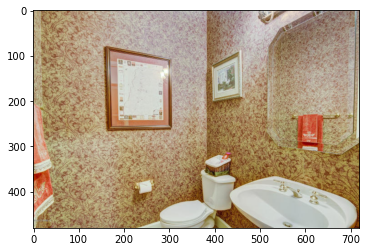

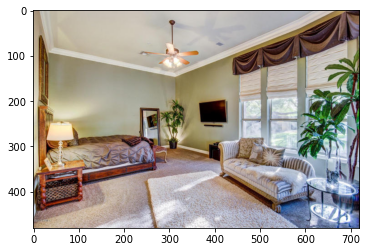

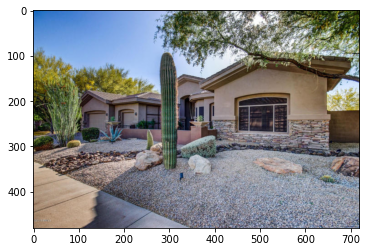

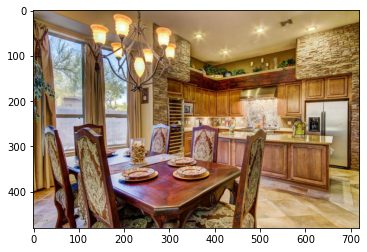

In [147]:
for name in sorted(list(glob.glob(os.path.sep.join(['data/Houses Dataset', "{}_*".format(1)])))):
    plt.imshow(cv2.imread(name)[..., ::-1])
    plt.show()

### Data Representation

We use a 64 * 64 matrix to represent visual data. We divide the matrix into 4 parts and each part consist one image.

In [148]:
images = []
for i in data.index.values:
    basepath = os.path.sep.join(['data/Houses Dataset', "{}_*".format(i + 1)]).replace('\\', '/')
    imgPaths = sorted(list(glob.glob(basepath)))
    inputImages = []
    for imgPath in imgPaths:
        image = cv2.resize(cv2.imread(imgPath), (32, 32))
        inputImages.append(image)
    outputImage = np.zeros((64, 64, 3), dtype='uint8')
    outputImage[0:32, 0:32] = inputImages[0]
    outputImage[0:32, 32:64] = inputImages[1]
    outputImage[32:64, 32:64] = inputImages[2]
    outputImage[32:64, 0:32] = inputImages[3]
    images.append(outputImage)

In [149]:
images = np.array(images)
images.shape

(535, 64, 64, 3)

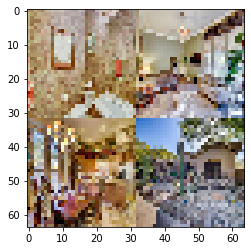

In [150]:
plt.imshow(images[0][..., ::-1])
plt.show()

### Data Preprocessing
* Scaling

In [151]:
X_train, X_test, IX_train, IX_test = train_test_split(data, images, random_state=5)

In [152]:
max_price = data['price'].max()
y_train = (X_train['price'] / max_price).values
y_test = (X_test['price'] / max_price).values

In [153]:
ss = StandardScaler()
XT = ss.fit_transform(X_train[['bedrooms', 'bathrooms', 'area']])
Xt = ss.transform(X_test[['bedrooms', 'bathrooms', 'area']])

Training data

In [154]:
print(XT.shape)
print(IX_train.shape)
print(y_train.shape)

(401, 3)
(401, 64, 64, 3)
(401,)


Testing data

In [155]:
print(Xt.shape)
print(IX_test.shape)
print(y_test.shape)

(134, 3)
(134, 64, 64, 3)
(134,)


### Modeling

In [206]:
input1 = Input(shape=(64, 64, 3))
conv1 = Conv2D(16, (3, 3), padding='same', activation='relu')(input1)
batchnorm1 = BatchNormalization(axis=-1)(conv1)
maxpool1 = MaxPooling2D(pool_size=(2, 2))(batchnorm1)

conv2 = Conv2D(32, (3, 3), padding='same', activation='relu')(maxpool1)
batchnorm2 = BatchNormalization(axis=-1)(conv2)
maxpool2 = MaxPooling2D(pool_size=(2, 2))(batchnorm2)

conv3 = Conv2D(64, (3, 3), padding='same', activation='relu')(maxpool2)
batchnorm3 = BatchNormalization(axis=-1)(conv3)
maxpool3 = MaxPooling2D(pool_size=(2, 2))(batchnorm3)

flatten1 = Flatten()(maxpool3)
dense1 = Dense(32, activation='relu')(flatten1)
batchnorm4 = BatchNormalization(axis=-1)(dense1)
dropout1 = Dropout(0.5)(batchnorm4)
dense2 = Dense(16, activation='relu')(dropout1)

In [207]:
m1 = Model(input1, dense2)

In [208]:
m2 = Sequential()
m2.add(Dense(16, activation='relu', input_dim=3))
m2.add(Dropout(0.5))
m2.add(Dense(8, activation='relu'))
m2.add(Dense(4, activation='relu'))

In [209]:
combinedModel = concatenate([m2.output, m1.output])

In [210]:
densef1 = Dense(8, activation='relu')(combinedModel)
densef2 = Dense(1, activation='linear')(densef1)
model = Model(inputs=[m2.input, m1.input], outputs=densef2)

In [184]:
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_17 (Conv2D)             (None, 64, 64, 16)   448         ['input_7[0][0]']                
                                                                                                  
 batch_normalization_23 (BatchN  (None, 64, 64, 16)  64          ['conv2d_17[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 max_pooling2d_17 (MaxPooling2D  (None, 32, 32, 16)  0           ['batch_normalization_23[0

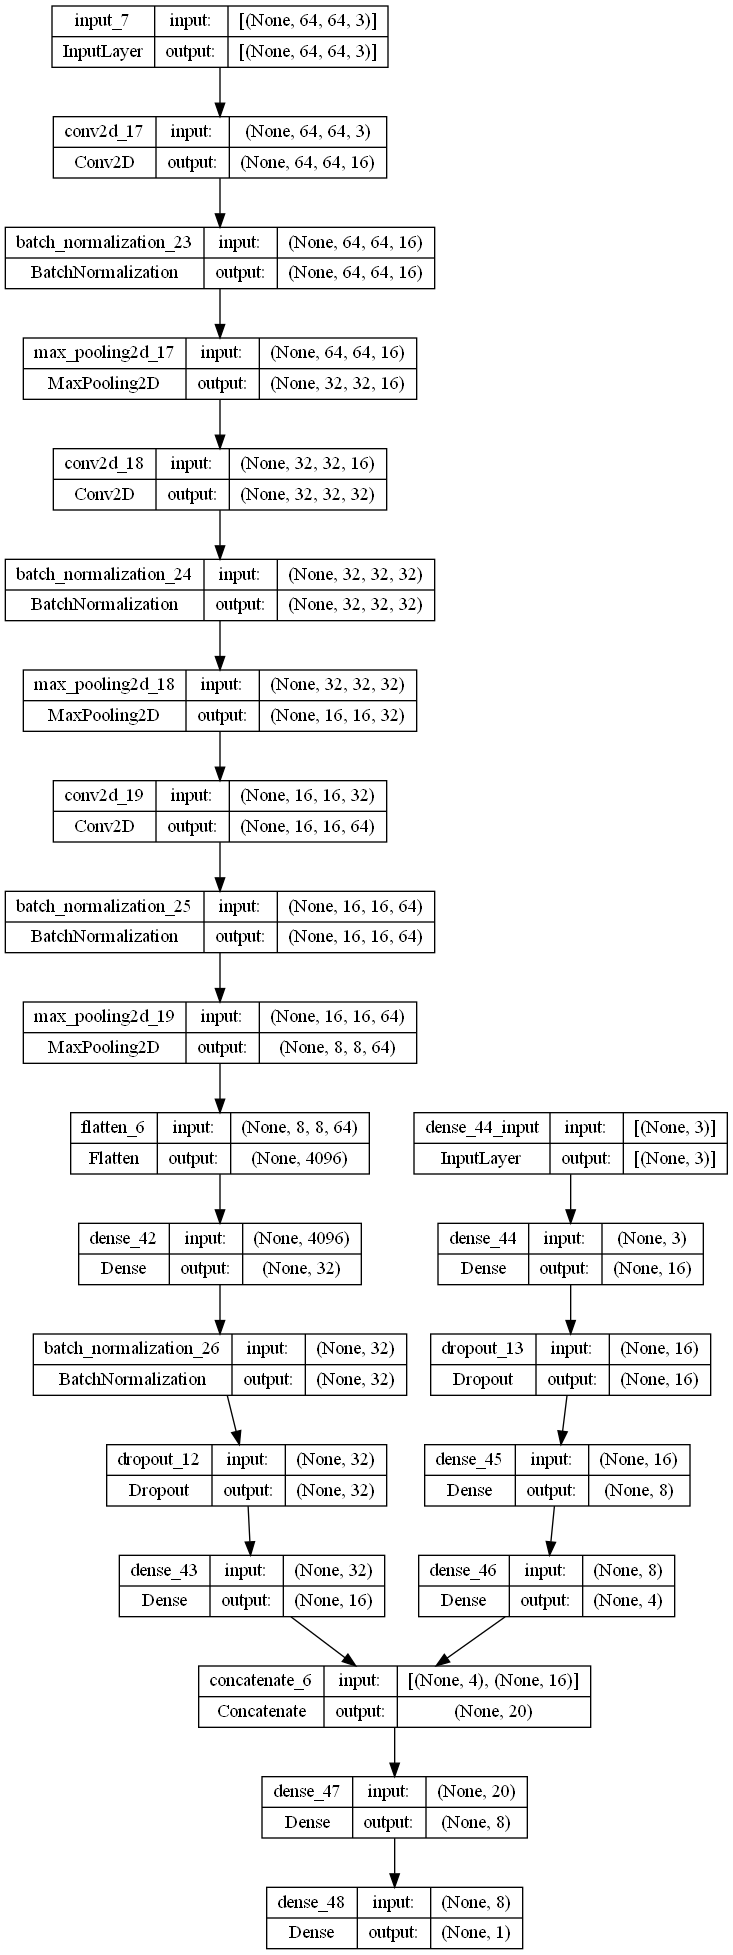

In [185]:
plot_model(model, show_shapes=True)

In [211]:
model.compile(loss='mean_absolute_error', optimizer=Adam(0.01))

In [212]:
model.fit([XT, IX_train], y_train, validation_data=([Xt, IX_test], y_test), epochs=52, batch_size=10)

Epoch 1/52
41/41 [==============================] - 3s 47ms/step - loss: 0.1420 - val_loss: 0.1446
Epoch 2/52
41/41 [==============================] - 2s 41ms/step - loss: 0.0653 - val_loss: 0.0552
Epoch 3/52
41/41 [==============================] - 2s 42ms/step - loss: 0.0573 - val_loss: 0.0914
Epoch 4/52
41/41 [==============================] - 2s 42ms/step - loss: 0.0545 - val_loss: 0.0529
Epoch 5/52
41/41 [==============================] - 2s 40ms/step - loss: 0.0527 - val_loss: 0.0414
Epoch 6/52
41/41 [==============================] - 2s 41ms/step - loss: 0.0490 - val_loss: 0.0442
Epoch 7/52
41/41 [==============================] - 2s 41ms/step - loss: 0.0483 - val_loss: 0.0457
Epoch 8/52
41/41 [==============================] - 2s 41ms/step - loss: 0.0475 - val_loss: 0.0417
Epoch 9/52
41/41 [==============================] - 2s 42ms/step - loss: 0.0451 - val_loss: 0.0449
Epoch 10/52
41/41 [==============================] - 2s 42ms/step - loss: 0.0459 - val_loss: 0.0482
Epoch 11/

### Evaluation

In [213]:
predicts = model.predict([Xt, IX_test]) * max_price

5/5 [==============================] - 0s 25ms/step


In [214]:
diff = abs(predicts.flatten() - (y_test * max_price))

In [215]:
diff.mean()

229602.98491626623

In [216]:
data['price'].mean()

589362.8112149533

In [218]:
r2_score(y_pred=predicts.flatten(), y_true=(y_test * max_price))

0.35437641176918944